In [5]:
#Importing all the required configurations
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time, copy, os
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
torch.__version__

'2.8.0+cu126'

In [8]:
torchvision.__version__

'0.23.0+cu126'

In [9]:
#Hyperparameters and directories
DATA_DIR = "./data"
BATCH_SIZE = 64
NUM_WORKERS = 4

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

#This code defines image preprocessing pipelines for training and testing — resizing images to 224×224 for ViT, applying data augmentation (flip, rotation) on training data, converting to tensors, and normalizing using ImageNet mean and standard deviation.

In [11]:
#Loading the dataset
train_dataset = datasets.CIFAR100(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=test_transform)

100%|██████████| 169M/169M [00:13<00:00, 12.1MB/s]


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [15]:
class_names = train_dataset.classes
print(f"CIFAR-100 loaded successfully with {len(class_names)} classes.")
print("Example classes:", class_names[:10])

CIFAR-100 loaded successfully with 100 classes.
Example classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']


In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, interpolation='nearest')  # avoid blur
    if title:
        plt.title(title)
    plt.axis('off')

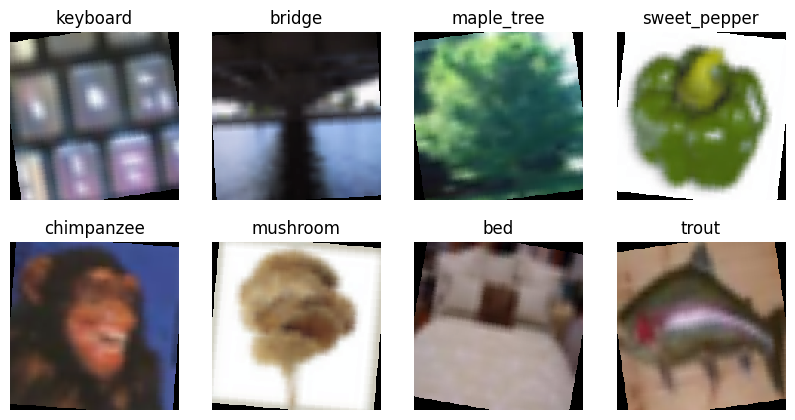

In [17]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i], class_names[labels[i]])
plt.show()

In [19]:
!pip install timm -q
import timm


In [21]:
import torch

# Detect GPU (CUDA or Apple MPS), else fallback to CPU
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

print(f"✅ Using device: {device}")


✅ Using device: cuda


In [22]:
model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=100)
model = model.to(device)

print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [24]:
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, 100)   # For CIFAR-100 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(" Vision Transformer model loaded and customized for 100 classes.")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:07<00:00, 43.4MB/s]


 Vision Transformer model loaded and customized for 100 classes.


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

Using: cuda


In [30]:
def train_one_epoch(model, dataloader, optimizer, criterion, device='cuda'):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [31]:
def evaluate(model, dataloader, criterion, device='cuda'):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [32]:
NUM_EPOCHS = 5
best_acc = 0.0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(NUM_EPOCHS):
    print(f"\n Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_cifar100.pt")
        print(" Saved Best Model")



 Epoch 1/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 3.6217, Train Acc: 14.38%
Val Loss: 3.2185, Val Acc: 21.20%
 Saved Best Model

 Epoch 2/5


Train Loss: 2.7325, Train Acc: 30.29%
Val Loss: 2.4931, Val Acc: 35.21%
 Saved Best Model

 Epoch 3/5


Train Loss: 2.2133, Train Acc: 40.97%
Val Loss: 2.1403, Val Acc: 42.55%
 Saved Best Model

 Epoch 4/5


Train Loss: 1.8466, Train Acc: 49.20%
Val Loss: 1.9481, Val Acc: 47.60%
 Saved Best Model

 Epoch 5/5


Train Loss: 1.5273, Train Acc: 57.22%
Val Loss: 1.8126, Val Acc: 51.55%
 Saved Best Model


Text(0.5, 1.0, 'Loss Curve')

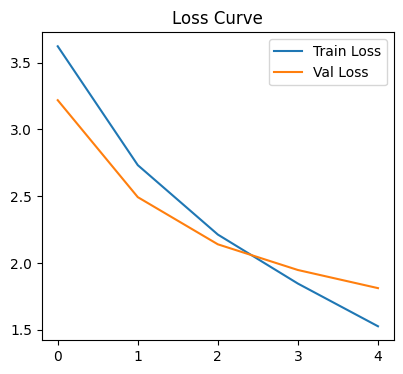

In [33]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss Curve')

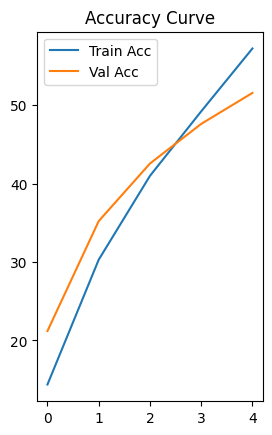

In [34]:
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')
plt.show()

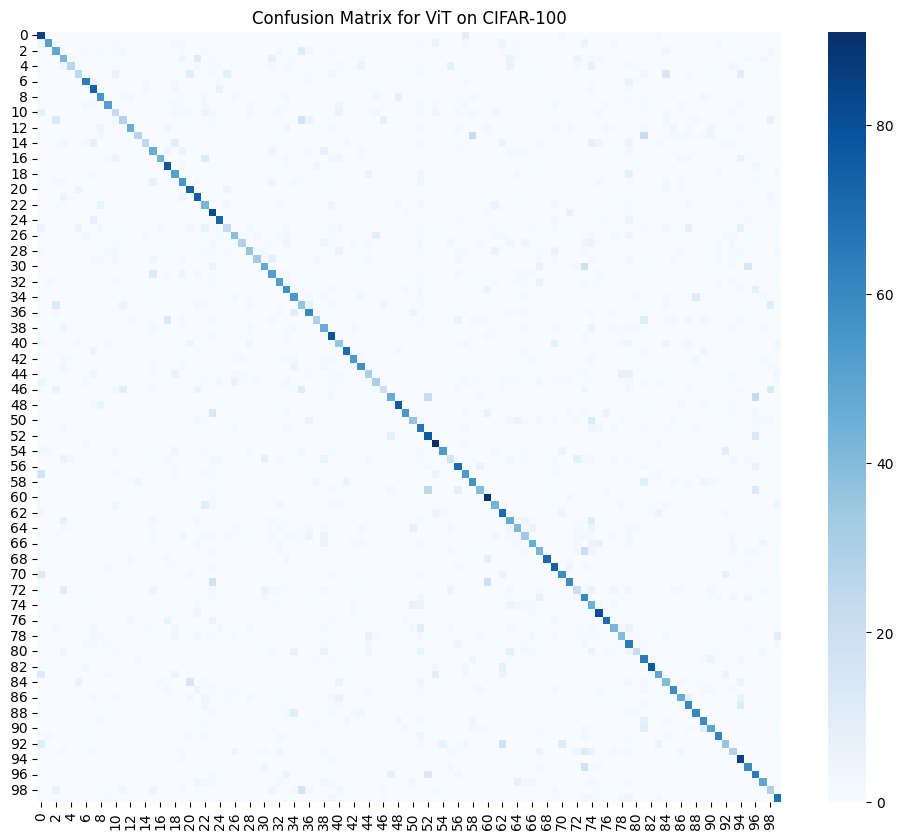

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix for ViT on CIFAR-100")
plt.show()
